In [1]:
import torch
import time
import matplotlib.pyplot as plt


In [2]:
torch.set_default_dtype(torch.float64)

In [ ]:
def POmega(X,Omega):
    ## Sampling operator
    ## Inputs:
    # X:        input tensor
    # Omega:    set of sampling index
    ## Outputs:
    # X_hat:    sampled tensor

    X_hat = torch.zeros_like(X)
    X_hat[Omega] = X[Omega]
    return X_hat

In [4]:
def HOSVD(X,r):
    
    ##1. Initialize the factor matrices and the core tensor
    d = len(X.shape)
    U = [torch.zeros(X.shape[i],r) for i in range(d)]

    ##2. reshape the tensor X to mode n unfolding and perform SVD
    for i in range(d):
        X_i = torch.moveaxis(X, i, 0).reshape(X.shape[i],-1)
        # perform the SVD for the mode i unfolding
        [u,_,_] = torch.linalg.svd(X_i,full_matrices=False)
        # factor matrix as the leading r columns of u
        U[i] = u[:, :r]

    ##3. Construct the core tensor
    U_kron = torch.ones(1)
    for i in range(1,d):
        U_kron = torch.kron(U_kron,U[i].T)
    X_1 = X.reshape(X.shape[0],-1)
    C = U[0].T@X_1@U_kron.T
    C = C.reshape([r for _ in range(d)])

    return [C,U]

In [5]:
def PTxM(X,A,r):
    ## Orthogonal projection of A onto tangenet space TxM
    ## Inputs:
    # X:        0_x of TxM
    # A:        input tensor
    # r:        rank of the tensor
    ## Outputs:
    # proj:     projection of E onto TxM

    d = len(A.shape)
    I = X.shape

    [C,U] = HOSVD(X,r)

    # G part
    U_kron = torch.ones(1)
    for i in range(1,d):
        U_kron = torch.kron(U_kron,U[i]@U[i].T)
    A_1 = A.reshape(A.shape[0],-1)
    G_part = U[0]@U[0].T@A_1@U_kron.T
    proj = G_part.reshape(I)

    # V part
    for i in range(d):
        C_i = torch.moveaxis(C, i, 0).reshape(C.shape[i],-1)

        U_kronT = torch.ones(1)
        for j in range(0,d):
            if j!=i:
                U_kronT = torch.kron(U_kronT,U[j].T)

        A_i = torch.moveaxis(A, i, 0).reshape(A.shape[i],-1)
        P_Ui_orth = torch.eye(I[i])-U[i]@U[i].T
        C_i_inv = C_i.T@((C_i@C_i.T).inverse())
        V_i = P_Ui_orth@A_i@U_kronT.T@ C_i_inv

        U_kron_V = torch.ones(1)
        for k in range(0,d):
            if k!=i:
                U_kron_V = torch.kron(U_kron_V,U[k])
        V_part = V_i@C_i@U_kron_V.T
        proj = proj + torch.moveaxis(V_part.reshape(I),0,i)


    return proj

In [6]:
def Rgrad(X,A,Omega,r):
    ## Riemannian gradient
    ## Inputs:
    # X:        X_k
    # A:        target tensor
    # Omega:    set of sampling index
    # r:        rank of the tensor
    ## Outputs:
    # grad:     riemannian gradient
    E = POmega(X, Omega) - POmega(A, Omega)
    grad = PTxM(X,E,r)

    return grad

In [7]:
def Retract(X,grad,r):
    ## Retraction
    [C,U] = HOSVD(X+grad,r)
    I = X.shape
    d = len(I)

    U_kron = torch.ones(1)
    for i in range(1,d):
        U_kron = torch.kron(U_kron,U[i])
    C_1 = C.reshape(C.shape[0],-1)
    X_proj = U[0]@C_1@U_kron.T
    X_proj = X_proj.reshape(I)

    return X_proj
    

In [8]:
def f(X,A,Omega):
    temp = POmega(X - A, Omega).reshape(-1)
    return torch.dot(temp,temp)/2

In [9]:
def RCG(A,X_0,Omega,Omega_test,r,max_iter=100,tol=1e-6):
    ## Riemannian Conjugate Gradient
    X_k = X_0
    eta_k = - Rgrad(X_k,A,Omega,r)
    # line search
    temp = POmega(eta_k,Omega).reshape(-1)
    alpha_k = torch.dot(temp,POmega(A-X_0,Omega).reshape(-1))/torch.dot(temp,temp)
    # retraction
    X_k = Retract(X_k,alpha_k*eta_k,r)
    # restore the previous gradient for beta_k
    Ep_km = -eta_k

    iter = 1
    err = torch.sqrt(f(X_k,A,Omega)/f(torch.zeros_like(A),A,Omega))

    Err = [torch.sqrt(f(X_k,A,Omega_test)/f(torch.zeros_like(A),A,Omega_test))]

    while iter <= max_iter and err > tol:
        Ep_k = Rgrad(X_k,A,Omega,r)
        # beta_k
        beta_k = torch.dot(Ep_k.reshape(-1),(Ep_k-PTxM(X_k,Ep_km,r)).reshape(-1))/torch.dot(Ep_km.reshape(-1),Ep_km.reshape(-1))
        beta_k = max(0,beta_k)
        # conjugate gradient
        eta_k = - Ep_k + beta_k*PTxM(X_k,eta_k,r)
        temp = POmega(eta_k,Omega).reshape(-1)
        alpha_k = torch.dot(temp,POmega(A-X_k,Omega).reshape(-1))/torch.dot(temp,temp)
        m = 0
        back = (2**-m)*alpha_k*eta_k
        LHS = f(X_k,A,Omega) - f(Retract(X_k,back,r),A,Omega)
        RHS = -1e-4*torch.dot(Ep_k.reshape(-1),back.reshape(-1))
        while LHS < RHS:
            m += 1
            back = (2**-m)*alpha_k*eta_k
            LHS = f(X_k,A,Omega) - f(Retract(X_k,back,r),A,Omega)
            RHS = -1e-4*torch.dot(Ep_k.reshape(-1),back.reshape(-1))
            print('LHS:',LHS)
            print('RHS:',RHS)
            if m > 3:
                print('backtracking line search after 5 steps')
                break
        
        X_k = Retract(X_k,back,r)
        Ep_km = Ep_k
        
        err = torch.sqrt(f(X_k,A,Omega)/f(torch.zeros_like(A),A,Omega))
        err_test = torch.sqrt(f(X_k,A,Omega_test)/f(torch.zeros_like(A),A,Omega_test))
        Err.append(err_test)
        print(f"Iteration {iter}: Training Error = {err:.6e}, Test Error = {err_test:.6e}")
        iter += 1

    return X_k,Err,iter

# Data

In [10]:
def data_generator(d, n, r):
    sz = [r for _ in range(d)]
    C = torch.rand(sz)

    I = [n for _ in range(d)]

    U = []
    U_kron = torch.ones(1)

    # Generate orthonormal basis matrices
    for i in range(d):
        U_i, R_i = torch.linalg.qr(torch.rand(n, r))
        U.append(U_i)

        C_i = torch.moveaxis(C, i, 0).reshape(C.shape[i],-1)
        C_i = R_i@C_i
        C = torch.moveaxis(C_i.reshape(sz), 0, i)

    for i in range(1,d):
        U_kron = torch.kron(U_kron,U[i])
        
    C_1 = C.reshape(C.shape[0],-1)
    A = U[0]@C_1@U_kron.T
    A = A.reshape(I)

    return C,U,A


In [11]:
# Example usage
d = 3  # Number of modes
n = 100  # Mode size
r = 5  # Multilinear rank


[C,U,A] = data_generator(d, n, r)

In [12]:
shape = [n for _ in range(d)]


samp_perc = 0.05
Omega = torch.rand(shape) < samp_perc
Omega_test = torch.rand(shape) < samp_perc
[_,_,X_init] = data_generator(d,n,r)

star_time = time.time()
A_hat_005,Err_test_005,iter_005 = RCG(A,X_init,Omega,Omega_test,r,tol=1e-12)
end_time = time.time()
time_005 = end_time - star_time


samp_perc = 0.1
Omega = torch.rand(shape) < samp_perc
Omega_test = torch.rand(shape) < samp_perc
[_,_,X_init] = data_generator(d,n,r)

star_time = time.time()
A_hat_005,Err_test_01,iter_01 = RCG(A,X_init,Omega,Omega_test,r,tol=1e-12)
end_time = time.time()
time_01 = end_time - star_time


samp_perc = 0.3
Omega = torch.rand(shape) < samp_perc
Omega_test = torch.rand(shape) < samp_perc
[_,_,X_init] = data_generator(d,n,r)

star_time = time.time()
A_hat_005,Err_test_03,iter_03 = RCG(A,X_init,Omega,Omega_test,r,tol=1e-12)
end_time = time.time()
time_03 = end_time - star_time


samp_perc = 0.5
Omega = torch.rand(shape) < samp_perc
Omega_test = torch.rand(shape) < samp_perc
[_,_,X_init] = data_generator(d,n,r)

star_time = time.time()
A_hat_005,Err_test_05,iter_5 = RCG(A,X_init,Omega,Omega_test,r,tol=1e-12)
end_time = time.time()
time_05 = end_time - star_time


Iteration 1: Training Error = 6.160305e-02, Test Error = 6.273288e-02
Iteration 2: Training Error = 2.517142e-02, Test Error = 2.646801e-02
Iteration 3: Training Error = 2.162452e-02, Test Error = 2.229075e-02
Iteration 4: Training Error = 1.828829e-02, Test Error = 1.859569e-02
Iteration 5: Training Error = 1.481536e-02, Test Error = 1.513098e-02
Iteration 6: Training Error = 1.075190e-02, Test Error = 1.103785e-02
Iteration 7: Training Error = 7.409025e-03, Test Error = 7.577295e-03
Iteration 8: Training Error = 5.210775e-03, Test Error = 5.319076e-03
Iteration 9: Training Error = 3.772032e-03, Test Error = 3.850988e-03
Iteration 10: Training Error = 2.491131e-03, Test Error = 2.526370e-03
Iteration 11: Training Error = 4.960970e-04, Test Error = 5.259863e-04
Iteration 12: Training Error = 1.080520e-04, Test Error = 1.152123e-04
Iteration 13: Training Error = 2.156554e-05, Test Error = 2.310373e-05
Iteration 14: Training Error = 4.839640e-06, Test Error = 5.189661e-06
Iteration 15: T

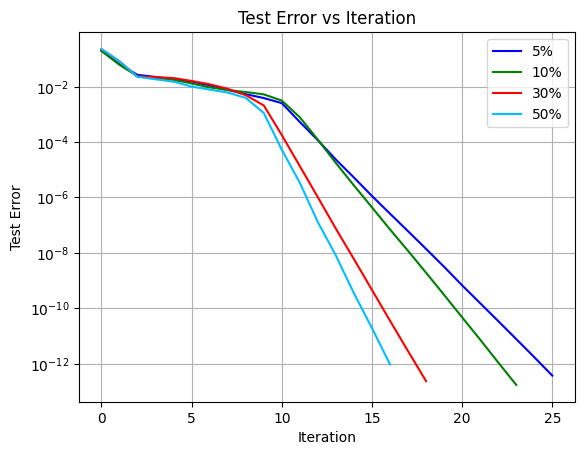

In [13]:
plt.semilogy(Err_test_005,label='5%',color = 'b')
plt.semilogy(Err_test_01,label='10%',color='g')
plt.semilogy(Err_test_03,label='30%',color='r')
plt.semilogy(Err_test_05,label='50%',color='deepskyblue')
plt.xlabel('Iteration')
plt.ylabel('Test Error')
plt.title('Test Error vs Iteration')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print(f"Time for  5% sampling: {time_005:.2f} seconds")
print(f"Time for 10% sampling: {time_01:.2f} seconds")
print(f"Time for 30% sampling: {time_03:.2f} seconds")
print(f"Time for 50% sampling: {time_05:.2f} seconds")

print(f"Iterations for  5% sampling: {iter_005}")
print(f"Iterations for 10% sampling: {iter_01}")
print(f"Iterations for 30% sampling: {iter_03}")
print(f"Iterations for 50% sampling: {iter_5}")

print(f"Average time per iteration for  5% sampling: {time_005/iter_005:.2f} seconds")
print(f"Average time per iteration for 10% sampling: {time_01/iter_01:.2f} seconds")
print(f"Average time per iteration for 30% sampling: {time_03/iter_03:.2f} seconds")
print(f"Average time per iteration for 50% sampling: {time_05/iter_5:.2f} seconds")

Time for 5% sampling: 33.44 seconds
Time for 10% sampling: 30.36 seconds
Time for 30% sampling: 25.68 seconds
Time for 50% sampling: 22.08 seconds
Iterations for 5% sampling: 26
Iterations for 10% sampling: 24
Iterations for 30% sampling: 19
Iterations for 50% sampling: 17
Average time per iteration for 5% sampling: 1.29 seconds
Average time per iteration for 10% sampling: 1.27 seconds
Average time per iteration for 30% sampling: 1.35 seconds
Average time per iteration for 50% sampling: 1.30 seconds


##### my 5% is the most time consuming one, while it is the least time consuming one in paper. 